In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle

OMNIGLOT_DATA = os.path.join(os.getcwd(), 'omniglot/')
DATASET_DIR = os.path.join(os.getcwd(), 'cluttered_omniglot/')

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 12.0)

import dataset_utils

from joblib import Parallel, delayed

### Create config file

In [16]:
config = dataset_utils.DatasetGeneratorConfig()

### Load Omniglot Dataset

In [3]:
def reorder_glots(glots):
    reordered_glots=[]
    for alph in range(len(glots)):
        for char in range(len(glots[alph])):
            reordered_glots.append(glots[alph][char])
    
    return reordered_glots

#Load glots from pickle file
path = OMNIGLOT_DATA

#Train split
with open(path + 'glots_train.pickle', 'rb') as fp:
    glots_train = pickle.load(fp)
    glots_train = reorder_glots(glots_train)
    
#Evaluation split
with open(path + 'glots_eval.pickle', 'rb') as fp:
    glots_eval = pickle.load(fp)
    glots_eval = reorder_glots(glots_eval)
    
#Test split
with open(path + 'glots_test.pickle', 'rb') as fp:
    glots_test = pickle.load(fp)
    glots_test = reorder_glots(glots_test)

### Dataset Generation Script

In [13]:
checksums = [[b'\xeb\xce\x01\x9a\xe7f\xbb\xaau;\xcd\xf1-\xea\xf9\xe5', 
              b'\x9f1\x0e\x90\xc5r\x11\xc9\xbb#\xd0\xa9\xc6&\xd6\xdd', 
              b"!h\x10\xeb'\xad\xe4\x81\xf2\xe0\xd8cun\x11\xff", 
              b'#\xacSz\xf1\xdc\xcc\xd9{\xaf\xf0pk\xf4N\xd1'], 
             [b'C\x1a\xbf0\x80@\xc1Hr(*\xc36\x89R\xfa', 
              b'\xa13\xe2\xf8\xbeX\x97P\x8e\xb87\xc4\xabH\xdc\xf5', 
              b';\x9apTq\n\xbf`CdR\xe8b\x85\xc4\xd9', 
              b'El\xd0\xfa\xc0\x9c<L\x1f\xf1o\xdai\x05\x14\x89'], 
             [b'\x08W\xafw\xa9\xa8\xea\xbd\xfa)\x14\xa4\xb4\xf0c\x13', 
              b'~\x8c\x84\x06`\x8bA\xb3m\xfb\xd4\xe4\x00\xb2\x83\x1a', 
              b'\x0cv\xa1.B\xfc\x16F\xb8u\xa4\xbap\x07\xbc\xe9', 
              b'\x02<\xe5\x1eg\xf7WWEr4]\xc2\xb1|='], 
             [b'/\xe56\xff\xec\xb2}\xa9\xe1\xec\xa1"\xdcV\x1dX', 
              b'\x0c\xc3\xd6N\xcc\x1e\xec\x03\x8a[J;[\n2|', 
              b'\xb5\xb7\x1di\xb1\xbb\xed\x7f\x08\xfc\x94.\xb4\xc6\xdcZ', 
              b'\xe5\xe2\x9a\x93\xfb\xf0ptJW\xb2\x9fv\xc7`$'], 
             [b'\xff\xec\x121\xe4\xd0K\xdd\x8c\x08\xf0.N\xc2%\xe0', 
              b'\x12\xe5X\xe8_\x92!7n\xdf\x94,KS\x0f\x7f', 
              b"T\x9f\xba\xe4\xa1hxq'\xf8\x91X\x93\xedC\xe5", 
              b'^\x1f@\\\xacUrX\xadR\n\xb5\xcd\xbb\xa6)'], 
             [b'\xd0\xa4\xbe\x038\xca\xf17r\xacg\xc3w5\xea\xa0', 
              b'\xd9W\xe5\xf3\xcc\x03w\xebL\xe6;\tl]\xf2\xfb', 
              b'\x90\x93\x15\xc9\xbb\xcd)\x96o\xf5\x18"|\r2X', 
              b'\x90\xf6!Ts\x1b7\xbb\xf0\xc4\x04\xcd\xcd\xe4\xc3\xdb'], 
             [b'*\x88\x88@\xc8\x11\xf4+\xab\x05\xfflE\xc1\xcd\x9b', 
              b'\x84\x02\xf3j\xf9\x99\xc0\x03\x9a\x05\xd1\x02\x97~\xbd\xaa', 
              b'\xbb\x12\x9f\xc4\t\xdd\xa2\xde\xeeW\x1b\xf58\xdb\x8f\xdc', 
              b"\x0fN\xc5\x87\x97\xda\xd6\x84x\xc6L'\x177Zz"]]

In [ ]:
# Generate indicidual datasets for each clutter level
nname =  [4, 8, 16, 32, 64, 128, 256]
nchars = [3, 7, 15, 31, 63, 127, 255]
# Generate one dataset for all clutter levels
# nname =  ['mix']
# nglots = [[3, 7, 15, 31, 63, 127, 255]]

for i in range(len(nname)):
    # Set and print saving directory
    dset_dir = DATASET_DIR + '{}_characters/'.format(nname[i])
    print('')
    print(dset_dir)

    # Set number of images per parallel job
    config.JOBLENGTH = 2000
    # Set number of distractors
    config.DISTRACTORS = nchars[i]
    
    ### Generate training set ###
    
    # Set dataset split
    config.DRAWER_SPLIT = 'train'
    config.set_drawer_split()
    # Define number of train images
    dataset_size = 2000000
    # Choose training alphabets
    glots = glots_train
    # Set path
    path = dset_dir + 'train/'
    # Set a fixed seed
    seed_train = 2209944264

    # Generate dataset
    #dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_train, save=True)


    ### Generate evaluation and test sets ###

    # Set dataset split
    config.DRAWER_SPLIT = 'val'
    config.set_drawer_split()
    # Define number of val/test images
    dataset_size = 10000

    #Generate evaluation set on train characters
    seed_val_train = 4020197800
    glots = glots_train
    path = dset_dir + 'val-train/'
    print('Generating dataset val-train/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_val_train, save=True, checksum=checksums[i][0])
    print('')
    
    #Generate test set on train characters
    seed_test_train = 1665765955
    glots = glots_train
    path = dset_dir + 'test-train/'
    print('Generating dataset val-train/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_test_train, save=True, checksum=checksums[i][1])
    print('')

    #Generate evaluation set on one-shot characters
    seed_val_one_shot = 3755213170
    glots = glots_eval
    path = dset_dir + 'val-one-shot/'
    print('Generating dataset val-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_val_one_shot, save=True, checksum=checksums[i][2])
    print('')

    #Generate test set on one-shot characters
    seed_test_one_shot = 2301871561
    glots = glots_test
    path = dset_dir + 'test-one-shot/'
    print('Generating dataset test-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_test_one_shot, save=True, checksum=checksums[i][3])
    print('')

print('')
print('All Done')

### Dataset Visualization Script

Executing 5 tasks
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


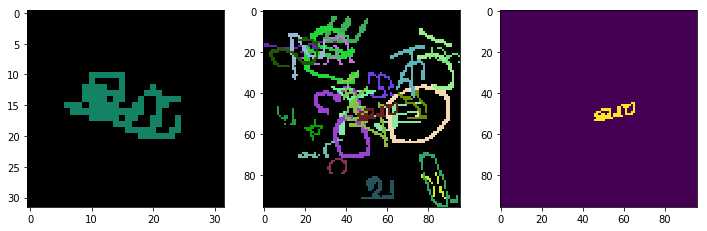

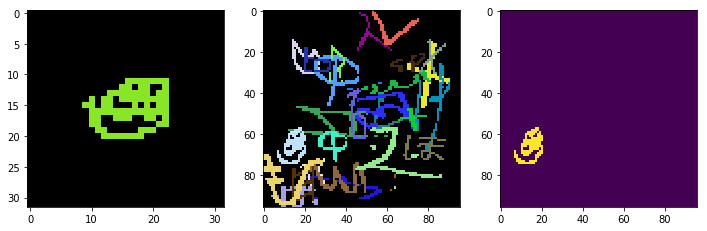

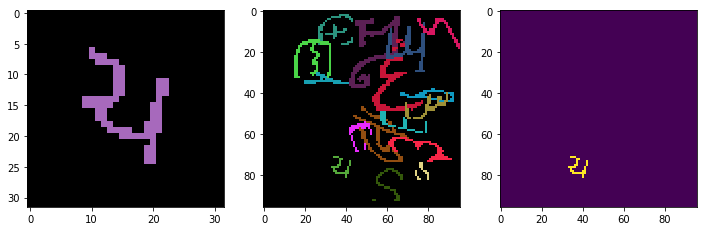

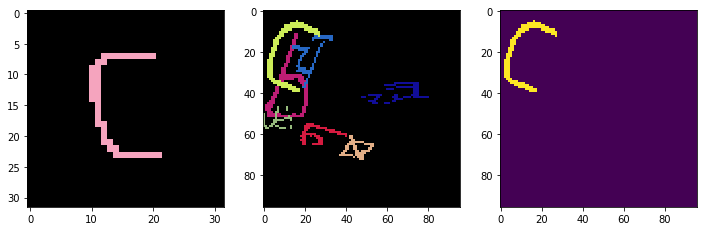

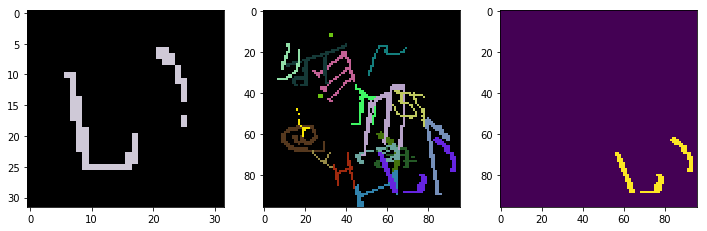

Duration: 12.384087800979614


In [10]:
#Show some randomly generated example images

# Define number of images
dataset_size = 5

# Choose training alphabets
glots = glots_train
# Set number of images per parallel job
config.JOBLENGTH = 1
# Set number of distractors
config.DISTRACTORS = 31
# Set dataset split
config.DRAWER_SPLIT = 'train'
config.set_drawer_split()

# set path if images should be saved
dset_dir = DATASET_DIR + '{}_characters/'.format(config.DISTRACTORS + 1)
path = DATASET_DIR + 'visualize/'

# Run visualization
dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=None, save=False, show=True)